In [3]:
import pandas as pd
import numpy as np

def getGameLogFeatureSet(gameDF):
    """
    Combina los datos de los partidos con las estadísticas de apuestas.

    Args:
        gameDF (pd.DataFrame): DataFrame con los datos de los partidos, incluyendo las columnas de apuestas.

    Returns:
        pd.DataFrame: DataFrame combinado con las estadísticas de los partidos y las apuestas.
    """

    def shiftGameLogRecords(gameDF):
        gameDF['LAST_GAME_OE'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['OFFENSIVE_EFFICIENCY'].shift(1)
        gameDF['LAST_GAME_HOME_WIN_PCTG'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['HOME_WIN_PCTG'].shift(1)
        gameDF['LAST_GAME_AWAY_WIN_PCTG'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['AWAY_WIN_PCTG'].shift(1)
        gameDF['LAST_GAME_TOTAL_WIN_PCTG'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['TOTAL_WIN_PCTG'].shift(1)
        gameDF['LAST_GAME_ROLLING_SCORING_MARGIN'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['ROLLING_SCORING_MARGIN'].shift(1)
        gameDF['LAST_GAME_ROLLING_OE'] = gameDF.sort_values('GAME_DATE').groupby(['TEAM_ID', 'SEASON'])['ROLLING_OE'].shift(1)

    def getHomeTeamFrame(gameDF):
        homeTeamFrame = gameDF[gameDF['CITY'] != 'OPPONENTS']
        homeTeamFrame = homeTeamFrame[['LAST_GAME_OE', 'LAST_GAME_HOME_WIN_PCTG', 'NUM_REST_DAYS', 'LAST_GAME_AWAY_WIN_PCTG',
                                       'LAST_GAME_TOTAL_WIN_PCTG', 'LAST_GAME_ROLLING_SCORING_MARGIN', 'LAST_GAME_ROLLING_OE',
                                       'W', 'TEAM_ID', 'GAME_ID', 'SEASON', 'Average_H']]

        colRenameDict = {}
        for col in homeTeamFrame.columns:
            if (col != 'GAME_ID') & (col != 'SEASON'):
                colRenameDict[col] = 'HOME_' + col

        homeTeamFrame.rename(columns=colRenameDict, inplace=True)

        return homeTeamFrame

    def getAwayTeamFrame(gameDF):
        awayTeamFrame = gameDF[gameDF['CITY'] == 'OPPONENTS']
        awayTeamFrame = awayTeamFrame[['LAST_GAME_OE', 'LAST_GAME_HOME_WIN_PCTG', 'NUM_REST_DAYS', 'LAST_GAME_AWAY_WIN_PCTG',
                                       'LAST_GAME_TOTAL_WIN_PCTG', 'LAST_GAME_ROLLING_SCORING_MARGIN', 'LAST_GAME_ROLLING_OE',
                                       'TEAM_ID', 'GAME_ID', 'SEASON', 'Average_A']]

        colRenameDict = {}
        for col in awayTeamFrame.columns:
            if (col != 'GAME_ID') & (col != 'SEASON'):
                colRenameDict[col] = 'AWAY_' + col

        awayTeamFrame.rename(columns=colRenameDict, inplace=True)

        return awayTeamFrame

    # Aplicar el desplazamiento de registros
    shiftGameLogRecords(gameDF)

    # Obtener los DataFrames de equipos locales y visitantes
    awayTeamFrame = getAwayTeamFrame(gameDF)
    homeTeamFrame = getHomeTeamFrame(gameDF)

    # Combinar los datos de equipos locales y visitantes
    combinedDF = pd.merge(homeTeamFrame, awayTeamFrame, how="inner", on=["GAME_ID", "SEASON"])

    # Eliminar columnas innecesarias
    combinedDF = combinedDF.drop(['GAME_ID', 'AWAY_TEAM_ID', 'HOME_TEAM_ID'], axis=1, errors='ignore')

    return combinedDF

In [4]:
import sqlite3
import pandas as pd

# Conectar a la base de datos SQLite
conexion = sqlite3.connect("C:\\Users\\andre\\Documents\\GitHub\\nba-data-analytics\\NBA_DATA.db")

# Leer todos los registros de la tabla GAMES
query = """
SELECT 
    gs.*,
    g.GAME_DATE,
    g.SEASON,
    ods.Average_H,
    ods.Average_A
FROM GAME_STATS gs
LEFT JOIN GAMES g ON gs.GAME_ID = g.GAME_ID
LEFT JOIN GAME_ODS ods ON gs.GAME_ID = ods.GAME_ID
"""
games_df = pd.read_sql_query(query, conexion)

# Cerrar la conexión
conexion.close()

# Mostrar los primeros registros del DataFrame
modelData = getGameLogFeatureSet(games_df)
modelData

,HOME_LAST_GAME_OE,HOME_LAST_GAME_HOME_WIN_PCTG,HOME_NUM_REST_DAYS,HOME_LAST_GAME_AWAY_WIN_PCTG,HOME_LAST_GAME_TOTAL_WIN_PCTG,HOME_LAST_GAME_ROLLING_SCORING_MARGIN,HOME_LAST_GAME_ROLLING_OE,HOME_W,SEASON,HOME_Average_H,AWAY_LAST_GAME_OE,AWAY_LAST_GAME_HOME_WIN_PCTG,AWAY_NUM_REST_DAYS,AWAY_LAST_GAME_AWAY_WIN_PCTG,AWAY_LAST_GAME_TOTAL_WIN_PCTG,AWAY_LAST_GAME_ROLLING_SCORING_MARGIN,AWAY_LAST_GAME_ROLLING_OE,AWAY_Average_A
0,0.561983,0.483871,2.0,0.454545,0.468750,0.666667,0.602820,1,2024-25,1.23,0.551181,0.363636,1.0,0.333333,0.349206,-9.333333,0.567970,4.40
1,0.661290,0.466667,2.0,0.454545,0.460317,0.666667,0.648050,1,2024-25,1.98,0.596639,0.655172,2.0,0.500000,0.573770,7.333333,0.615546,1.88
2,0.585185,0.448276,2.0,0.454545,0.451613,-6.666667,0.615792,1,2024-25,2.35,0.609375,0.655172,2.0,0.516129,0.583333,7.666667,0.637097,1.62
3,0.697674,0.464286,1.0,0.454545,0.459016,-12.000000,0.618470,0,2024-25,2.75,0.647059,0.700000,3.0,0.448276,0.576271,7.000000,0.556985,1.49
4,0.637795,0.733333,2.0,0.533333,0.633333,0.000000,0.616567,0,2024-25,1.34,0.564516,0.464286,3.0,0.437500,0.450000,-8.666667,0.574437,3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10770,0.516129,0.750000,3.0,0.500000,0.625000,4.666667,0.537267,1,2024-25,1.25,0.500000,0.600000,3.0,0.500000,0.555556,-4.666667,0.544405,4.30
10771,0.586207,0.750000,2.0,0.500000,0.625000,-2.000000,0.555705,0,2024-25,2.95,0.504762,0.750000,2.0,0.333333,0.571429,2.000000,0.525717,1.44
10772,0.547009,0.666667,3.0,0.500000,0.571429,0.666667,0.567953,1,2024-25,2.85,0.590909,0.750000,3.0,0.500000,0.666667,15.000000,0.552585,1.47
10773,0.481481,0.666667,3.0,0.500000,0.600000,10.333333,0.563949,1,2024-25,1.18,0.533898,0.666667,3.0,0.666667,0.666667,0.333333,0.542849,5.20


In [5]:
data = modelData
data = data.dropna()
data

,HOME_LAST_GAME_OE,HOME_LAST_GAME_HOME_WIN_PCTG,HOME_NUM_REST_DAYS,HOME_LAST_GAME_AWAY_WIN_PCTG,HOME_LAST_GAME_TOTAL_WIN_PCTG,HOME_LAST_GAME_ROLLING_SCORING_MARGIN,HOME_LAST_GAME_ROLLING_OE,HOME_W,SEASON,HOME_Average_H,AWAY_LAST_GAME_OE,AWAY_LAST_GAME_HOME_WIN_PCTG,AWAY_NUM_REST_DAYS,AWAY_LAST_GAME_AWAY_WIN_PCTG,AWAY_LAST_GAME_TOTAL_WIN_PCTG,AWAY_LAST_GAME_ROLLING_SCORING_MARGIN,AWAY_LAST_GAME_ROLLING_OE,AWAY_Average_A
0,0.561983,0.483871,2.0,0.454545,0.468750,0.666667,0.602820,1,2024-25,1.23,0.551181,0.363636,1.0,0.333333,0.349206,-9.333333,0.567970,4.40
1,0.661290,0.466667,2.0,0.454545,0.460317,0.666667,0.648050,1,2024-25,1.98,0.596639,0.655172,2.0,0.500000,0.573770,7.333333,0.615546,1.88
2,0.585185,0.448276,2.0,0.454545,0.451613,-6.666667,0.615792,1,2024-25,2.35,0.609375,0.655172,2.0,0.516129,0.583333,7.666667,0.637097,1.62
3,0.697674,0.464286,1.0,0.454545,0.459016,-12.000000,0.618470,0,2024-25,2.75,0.647059,0.700000,3.0,0.448276,0.576271,7.000000,0.556985,1.49
4,0.637795,0.733333,2.0,0.533333,0.633333,0.000000,0.616567,0,2024-25,1.34,0.564516,0.464286,3.0,0.437500,0.450000,-8.666667,0.574437,3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10770,0.516129,0.750000,3.0,0.500000,0.625000,4.666667,0.537267,1,2024-25,1.25,0.500000,0.600000,3.0,0.500000,0.555556,-4.666667,0.544405,4.30
10771,0.586207,0.750000,2.0,0.500000,0.625000,-2.000000,0.555705,0,2024-25,2.95,0.504762,0.750000,2.0,0.333333,0.571429,2.000000,0.525717,1.44
10772,0.547009,0.666667,3.0,0.500000,0.571429,0.666667,0.567953,1,2024-25,2.85,0.590909,0.750000,3.0,0.500000,0.666667,15.000000,0.552585,1.47
10773,0.481481,0.666667,3.0,0.500000,0.600000,10.333333,0.563949,1,2024-25,1.18,0.533898,0.666667,3.0,0.666667,0.666667,0.333333,0.542849,5.20


In [12]:
data = games_df[['GAME_ID', 'GAME_DATE', 'HOME_FLAG', 'W', 'Average_H']].copy()
data.columns = ['GAME_ID', 'date', 'HOME_FLAG', 'result', 'odds']
data['stake'] = 100

In [42]:
df_to_validate = data[(data['HOME_FLAG'] == 1) & (data['odds'] < 2)].drop(['HOME_FLAG', 'GAME_ID'], axis=1).sort_values('date')

In [43]:
df_to_validate

,date,result,odds,stake
20518,2017-09-30 00:00:00,0,1.25,100
20470,2017-10-01 00:00:00,1,1.36,100
20544,2017-10-01 00:00:00,1,1.80,100
20508,2017-10-02 00:00:00,1,1.50,100
20578,2017-10-02 00:00:00,1,1.83,100
...,...,...,...,...
21526,2025-05-31 00:00:00,1,1.58,100
21548,2025-06-05 00:00:00,0,1.21,100
21546,2025-06-08 00:00:00,1,1.18,100
21540,2025-06-16 00:00:00,1,1.25,100


In [36]:
def calcular_estadisticas(df):
    total_bets = len(df)
    df['profit'] = np.where(df['result'] == 1, df['odds'] * df['stake'] - df['stake'], -df['stake'])
    wins = df[df['result'] == 1]
    loses = df[df['result'] == 0]
    roi = df['profit'].sum() / df['stake'].sum()
    yield_ = df['profit'].sum() / total_bets
    winrate = len(wins) / total_bets

    return {
        "Total Bets": total_bets,
        "ROI": round(roi, 4),
        "Yield": round(yield_, 2),
        "Winrate": round(winrate * 100, 2)
    }

In [ ]:
import matplotlib.pyplot as plt

def return_grafic(df):
    df['profit'] = np.where(df['result'] == 1, df['odds'] * df['stake'] - df['stake'], -df['stake'])
    df['accumulated'] = df['profit'].cumsum()
    plt.plot(df['date'], df['accumulated'])
    plt.title("Cumulative gain over time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative gain")
    plt.grid()
    plt.show()

In [40]:
calcular_estadisticas(df_to_validate)

{'Total Bets': 6981, 'ROI': -0.0483, 'Yield': -4.83, 'Winrate': 67.54}

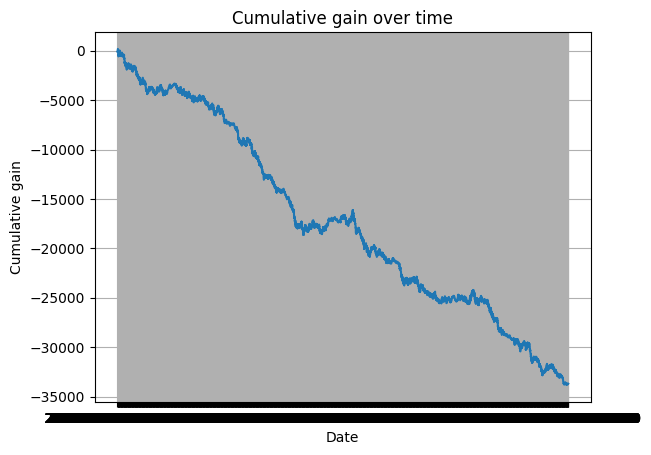

In [44]:
return_grafic(df_to_validate)

In [ ]:
df_to_validate['accumulated'] = df_to_validate['profit'].cumsum()
df_to_validate[]

,date,result,odds,stake,profit,accumulated
0,2025-03-10 00:00:00,1,1.23,100,23.0,23.0
2,2025-03-08 00:00:00,1,1.98,100,98.0,121.0
4,2025-03-06 00:00:00,1,2.35,100,135.0,256.0
6,2025-03-04 00:00:00,0,2.75,100,175.0,431.0
8,2025-03-03 00:00:00,0,1.34,100,34.0,465.0
...,...,...,...,...,...,...
21540,2025-06-16 00:00:00,1,1.25,100,25.0,1118155.0
21542,2025-06-13 00:00:00,0,2.95,100,195.0,1118350.0
21544,2025-06-11 00:00:00,1,2.85,100,185.0,1118535.0
21546,2025-06-08 00:00:00,1,1.18,100,18.0,1118553.0


In [27]:
df_to_validate['result']


0        1
2        1
4        1
6        0
8        0
        ..
21540    1
21542    0
21544    1
21546    1
21548    0
Name: result, Length: 10775, dtype: int64